# Team Name : Hadoop Heroes 
### Team Members :
##### Akhil Vayunandan Reddy Ankireddypalli
##### Haritha Karna
##### Sree Krishnakanth Gurram
##### Sri Venkata Likhitha Duggi

# Business Research Question

Our core objective is to create a predictive model for accurately estimating trip fare prices. By leveraging source and destination details, trip distance, historical extra charges, passenger count, and airport involvement, this solution aims to provide reliable fare predictions, benefiting both passengers and ride-sharing services. 

## Business Value
1. Enhanced Ride-sharing Services:
Accurate fare predictions empower ride-sharing services like yellow taxis to optimize pricing strategies, providing passengers with fair and competitive fares. This fosters customer loyalty and boosts service utilization.

2. Passenger Financial Planning:
Reliable fare predictions enable passengers to plan their transportation budgets more effectively. Passengers can estimate their trip fare based on distance, pickup and drop off locations. They can make informed decisions about their travel expenses, helping them manage their finances.

3. Optimized Traffic Management:
Analyzing busy routes provides insights into the flow of traffic and helps transportation authorities and service providers better manage and optimize the use of road infrastructure.


# Dataset Description
The New York City Taxi and Limousine Commission (TLC) Trip Record Data is a comprehensive dataset that provides detailed information on taxi and for-hire vehicle trips within New York City. This dataset offers a rich source of information, including trip date and time, pickup and drop-off locations, trip distances, fare amounts, and additional charges. With millions of records, it offers valuable insights into transportation trends, passenger behaviors, and traffic patterns. Researchers, analysts, and businesses can utilize this dataset for various applications, including transportation optimization, urban planning, and data-driven decision-making in the transportation industry.

Prior to loading the data for this project, we created anothe ipynb file that converts PARQUET file to csv file and performed data cleaning on it.

### Features
1. VendorID : A code indicating the TPEP provider that provided the record. 1= Creative Mobile Technologies, LLC; 2= VeriFone Inc
2. tpep_pickup_datetime : The date and time when the meter was engaged
3. tpep_dropoff_datetime : The date and time when the meter was disengaged
4. Passenger_count : The number of passengers in the vehicle. This is a driver-entered value
5. Trip_distance : The elapsed trip distance in miles reported by the taximeter
6. PULocationID : TLC Taxi Zone in which the taximeter was engaged
7. DOLocationID : TLC Taxi Zone in which the taximeter was disengaged
8. Fare_amount : The time-and-distance fare calculated by the meter
9. Extra : Miscellaneous extras and surcharges
10. Tip_amount : This field is automatically populated for credit card tips. Cash tips are not included
11. Total_amount : The total amount charged to passengers. Does not include cash tips
12. Airport_fee : $1.25 for pick up only at LaGuardia and John F. Kennedy Airports

## Choice of Models
Our problem is predicting a continuous variable and hence it falls under Regression analysis. We will be building three models to predict the fare amount:
    
1. Linear Regression
2. Decision Tree
3. Random Forest


# Data Explorations that we plan on doing:
1. Number of trips by each vendor
2. Number of trips by pickup and dropoff location
3. Which vendor provides a better service?
4. What is the average fare for the trips with extra charges?
5. What is the average total amount collected for trips with more than 2 passengers ?
6. What is the average trip distance for each passenger count?
7. What is the relation between trip distance and fare amount ?


### Importing libraries and creating spark context 

In [1]:
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf

In [2]:
#datawarehouse_location points to the default location for managed databases and tables
from os.path import abspath
warehouse_location = abspath('spark-warehouse')
spark = SparkSession.builder \
        .master("local[*]") \
        .appName("ISM6562 Spark Project") \
        .enableHiveSupport() \
        .getOrCreate()

spark_session_port = spark.sparkContext.uiWebUrl.split(":")[-1]
print("Spark Session WebUI Port: " + spark_session_port)

23/11/10 17:29:11 WARN Utils: Your hostname, localhost.localdomain resolves to a loopback address: 127.0.0.1; using 10.21.10.196 instead (on interface eth0)
23/11/10 17:29:11 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/11/10 17:29:12 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Spark Session WebUI Port: 4040


In [3]:
spark 

## Load data to spark dataframe 

In [4]:
trips = spark.read.csv('data/yellow_tripdata_2022-02.csv' , header = True , inferSchema=True)

# display the first 10 rows of the dataframe 
trips.show(10)

+--------+--------------------+---------------------+---------------+-------------+------------+------------+-----------+-----+----------+------------+-----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|PULocationID|DOLocationID|fare_amount|extra|tip_amount|total_amount|airport_fee|
+--------+--------------------+---------------------+---------------+-------------+------------+------------+-----------+-----+----------+------------+-----------+
|       1|    02-01-2022 00:06|     02-01-2022 00:19|              1|          5.4|         138|         252|       17.0| 1.75|       3.9|       23.45|       1.25|
|       1|    02-01-2022 00:38|     02-01-2022 00:55|              1|          6.4|         138|          41|       21.0| 1.75|       0.0|        30.1|       1.25|
|       1|    02-01-2022 00:03|     02-01-2022 00:26|              1|         12.5|         138|         200|       35.5| 1.75|       0.0|        44.6|       1.25|
|       2|    02

In [5]:
trips.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: string (nullable = true)
 |-- tpep_dropoff_datetime: string (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- airport_fee: double (nullable = true)



## Data-preprocessing

Create a database and table in spark 

In [6]:
trips.createOrReplaceTempView("trips_tmp_view")

In [7]:
df= spark.sql("SELECT * FROM trips_tmp_view")
df.show(10)

+--------+--------------------+---------------------+---------------+-------------+------------+------------+-----------+-----+----------+------------+-----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|PULocationID|DOLocationID|fare_amount|extra|tip_amount|total_amount|airport_fee|
+--------+--------------------+---------------------+---------------+-------------+------------+------------+-----------+-----+----------+------------+-----------+
|       1|    02-01-2022 00:06|     02-01-2022 00:19|              1|          5.4|         138|         252|       17.0| 1.75|       3.9|       23.45|       1.25|
|       1|    02-01-2022 00:38|     02-01-2022 00:55|              1|          6.4|         138|          41|       21.0| 1.75|       0.0|        30.1|       1.25|
|       1|    02-01-2022 00:03|     02-01-2022 00:26|              1|         12.5|         138|         200|       35.5| 1.75|       0.0|        44.6|       1.25|
|       2|    02

In [8]:
type(trips)

pyspark.sql.dataframe.DataFrame

In [9]:
spark.sql("CREATE DATABASE IF NOT EXISTS trips_db;")

23/11/10 17:29:22 WARN HiveConf: HiveConf of name hive.stats.jdbc.timeout does not exist
23/11/10 17:29:22 WARN HiveConf: HiveConf of name hive.stats.retries.wait does not exist
23/11/10 17:29:25 WARN ObjectStore: Version information not found in metastore. hive.metastore.schema.verification is not enabled so recording the schema version 2.3.0
23/11/10 17:29:25 WARN ObjectStore: setMetaStoreSchemaVersion called but recording version is disabled: version = 2.3.0, comment = Set by MetaStore student@127.0.0.1


DataFrame[]

In [10]:
trips.write.mode("overwrite").saveAsTable("trips_db.trips")

23/11/10 17:29:26 WARN ObjectStore: Failed to get database global_temp, returning NoSuchObjectException
23/11/10 17:29:27 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
23/11/10 17:29:27 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 84.44% for 9 writers
23/11/10 17:29:27 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 76.00% for 10 writers
23/11/10 17:29:27 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 69.09% for 11 writers
23/11/10 17:29:27 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 63.33% for 12 writers
23/11/10 17:29:27 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row

Listing tables in the created database

In [11]:
spark.catalog.listTables('trips_db')

[Table(name='trips', catalog='spark_catalog', namespace=['trips_db'], description=None, tableType='MANAGED', isTemporary=False),
 Table(name='trips_tmp_view', catalog=None, namespace=[], description=None, tableType='TEMPORARY', isTemporary=True)]

In [12]:
df = spark.sql("SELECT * FROM trips_db.trips")
df.show(10)

+--------+--------------------+---------------------+---------------+-------------+------------+------------+-----------+-----+----------+------------+-----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|PULocationID|DOLocationID|fare_amount|extra|tip_amount|total_amount|airport_fee|
+--------+--------------------+---------------------+---------------+-------------+------------+------------+-----------+-----+----------+------------+-----------+
|       2|    02-01-2022 20:44|     02-01-2022 21:08|              1|         5.74|         107|           7|       20.5|  0.5|      4.86|       29.16|        0.0|
|       1|    02-01-2022 20:35|     02-01-2022 20:44|              1|          1.3|         230|         229|        7.0|  3.0|       0.0|        10.8|        0.0|
|       2|    02-01-2022 20:11|     02-01-2022 20:33|              1|         4.37|          79|         236|       18.0|  0.5|      4.36|       26.16|        0.0|
|       2|    02

In [13]:
df = spark.sql(" describe trips_db.trips")
df.show()

+--------------------+---------+-------+
|            col_name|data_type|comment|
+--------------------+---------+-------+
|            VendorID|      int|   NULL|
|tpep_pickup_datetime|   string|   NULL|
|tpep_dropoff_date...|   string|   NULL|
|     passenger_count|      int|   NULL|
|       trip_distance|   double|   NULL|
|        PULocationID|      int|   NULL|
|        DOLocationID|      int|   NULL|
|         fare_amount|   double|   NULL|
|               extra|   double|   NULL|
|          tip_amount|   double|   NULL|
|        total_amount|   double|   NULL|
|         airport_fee|   double|   NULL|
+--------------------+---------+-------+



# Data Exploration using PySpark SQL

### Number of trips by each Vendor

In [14]:
vendor1_trips = spark.sql("""SELECT COUNT(VendorID) as vendorID1 
    FROM trips_db.trips 
    WHERE VendorID=1""")

vendor1_trips_1=vendor1_trips.first().vendorID1

print("Number of trips taken by Vendor 1 - Creative Mobile Technologies, LLC:", vendor1_trips_1)

Number of trips taken by Vendor 1 - Creative Mobile Technologies, LLC: 319007


In [15]:
vendor2_trips = spark.sql("""SELECT COUNT(VendorID) as vendorID2 
    FROM trips_db.trips 
    WHERE VendorID=2""")

vendor2_trips_2=vendor2_trips.first().vendorID2

print("Number of trips taken by Vendor 2 - VeriFone Inc:", vendor2_trips_2)

Number of trips taken by Vendor 2 - VeriFone Inc: 724578


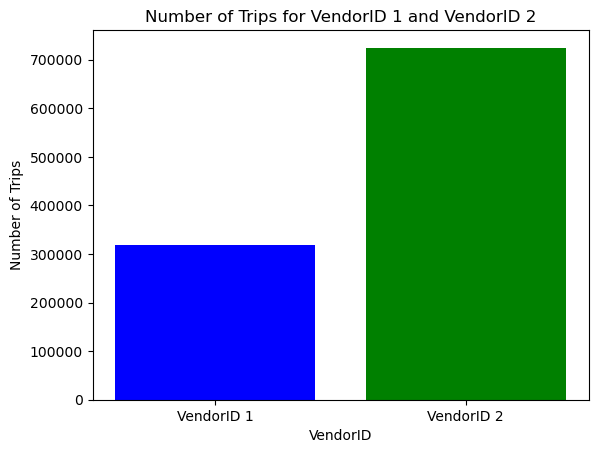

In [16]:
import matplotlib.pyplot as plt

# Convert the result to Pandas for easy plotting
vendor1_count = vendor1_trips.toPandas()['vendorID1'][0]
vendor2_count = vendor2_trips.toPandas()['vendorID2'][0]

# Plotting the bar chart
vendors = ['VendorID 1', 'VendorID 2']
counts = [vendor1_count, vendor2_count]

plt.bar(vendors, counts, color=['blue', 'green'])
plt.title('Number of Trips for VendorID 1 and VendorID 2')
plt.xlabel('VendorID')
plt.ylabel('Number of Trips')
plt.show()


Analysis:

Creative Mobile Technologies LLC and VeriFone Inc had 319007, 724578 trips each in total
VeriFone Inc took more than twice the number of trips of Creative Mobile Technologies LLC

### Number of trips by pickup and dropoff location 

In [17]:
# count of each pickup location 

pickup_trips = spark.sql("""SELECT PULocationID, COUNT(*) AS pickup_count 
    FROM trips_db.trips 
    GROUP BY PULocationID
    ORDER BY pickup_count DESC""")

# Convert the DataFrame to a Pandas DataFrame
pickup_trips_pandas = pickup_trips.toPandas()

# Print the Pandas DataFrame
print(pickup_trips_pandas.head(10))


   PULocationID  pickup_count
0           237         55209
1           236         52974
2           161         41126
3           162         35420
4           142         34384
5           186         34369
6           170         33203
7           132         32341
8           239         32263
9            48         31510


In [18]:
# count of each dropoff location 

dropoff_trips = spark.sql("""SELECT DOLocationID, COUNT(*) AS dropoff_count 
    FROM trips_db.trips
    GROUP BY DOLocationID 
    ORDER BY dropoff_count DESC""")

# Convert the DataFrame to a Pandas DataFrame
dropoff_trips_pandas = dropoff_trips.toPandas()

# Print the Pandas DataFrame
print(dropoff_trips_pandas.head(10))


   DOLocationID  dropoff_count
0           236          54140
1           237          48257
2           161          34393
3           239          32257
4           170          32028
5           141          31752
6           142          29920
7           238          28305
8            48          27783
9           162          26909


The most frequent pick up and drop off location are  Taxi Zones 237 & 236

### Which vendor provides a better service? 

(Assumption : Tipping being a metric for good service)

In [19]:
avg_tip_per_vendor = spark.sql("""SELECT VendorID, ROUND(AVG(tip_amount),2) AS avg_tip 
    FROM trips_db.trips 
    GROUP BY VendorID 
    ORDER BY avg_tip DESC """)

avg_tip_per_vendor_pandas=avg_tip_per_vendor.toPandas()
print(avg_tip_per_vendor_pandas)

   VendorID  avg_tip
0         2     2.48
1         1     2.33


Analysis:

The avg_tip difference between both vendors is minimal.
However, based on the values, Vendor 2's service is better.

### What is the average fare for the trips with extra charges? 

In [20]:
avg_fare_amount_extra = spark.sql("""SELECT ROUND(AVG(fare_amount),2) as avg_fare_amount 
    FROM trips_db.trips 
    WHERE extra > 0""")

# Extract the average fare amount value
average_fare = avg_fare_amount_extra.first()[0]

# Print the statement
print(f"Average Fare for trips with extra charge is: ${average_fare:.2f}")

Average Fare for trips with extra charge is: $12.13


### What is the average total amount collected for trips with more than 2 passengers ? 

In [21]:
avg_total_for_large_groups = spark.sql("""SELECT ROUND(AVG(total_amount),2) as total_fare 
    FROM trips_db.trips  
    WHERE passenger_count > 2""")

# Extract the average fare amount value
average_total = avg_total_for_large_groups.first()[0]

# Print the statement
print(f"Average total amount for trips with more than 2 passengers: ${average_total:.2f}")

Average total amount for trips with more than 2 passengers: $19.23


### What is the average trip distance for each passenger count? 

In [22]:
avg_distance_per_passenger = spark.sql("""SELECT passenger_count, ROUND(AVG(trip_distance),2) as avg_distance 
    FROM trips_db.trips 
    GROUP BY passenger_count
    ORDER BY passenger_count""")

avg_distance_per_passenger_pandas = avg_distance_per_passenger.toPandas()
print(avg_distance_per_passenger_pandas)

   passenger_count  avg_distance
0                0          2.61
1                1          2.84
2                2          3.23
3                3          3.02
4                4          3.10
5                5          2.90
6                6          2.92
7                7          0.73
8                8          1.66
9                9          0.00


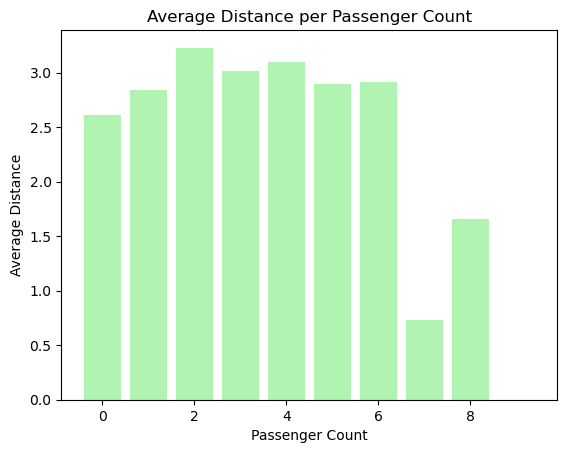

In [23]:
import matplotlib.pyplot as plt

plt.bar(avg_distance_per_passenger_pandas['passenger_count'], avg_distance_per_passenger_pandas['avg_distance'], color='lightgreen', alpha=0.7)
plt.xlabel('Passenger Count')
plt.ylabel('Average Distance')
plt.title('Average Distance per Passenger Count')
plt.show() 

### What is the relation between trip distance and fare amount ? 

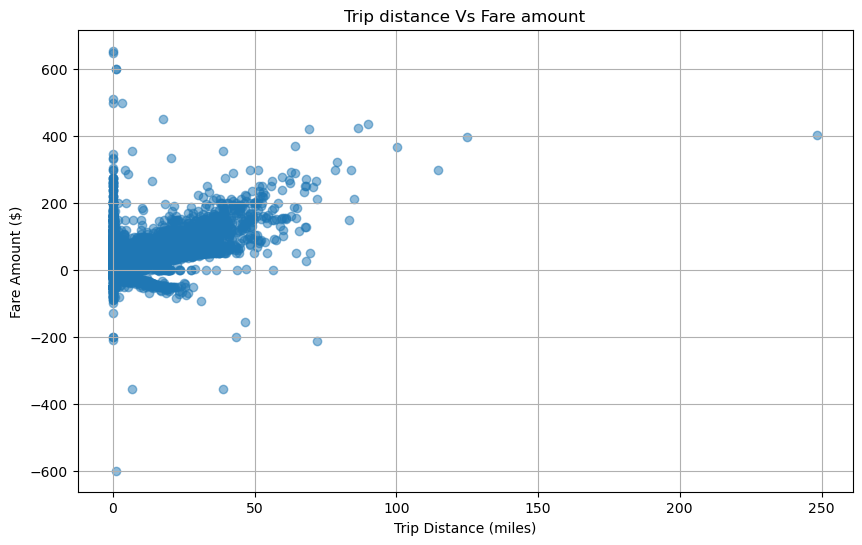

In [24]:
trips_pd = trips.toPandas()

# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(trips_pd['trip_distance'], trips_pd['fare_amount'], alpha=0.5)
plt.title('Trip distance Vs Fare amount')
plt.xlabel('Trip Distance (miles)')
plt.ylabel('Fare Amount ($)')
plt.grid(True)
plt.show()

Analysis

From the above scatter plot, general trend seems to increase in fare amount for every additional mile travelled . 
Negative fares might represent refund amount for cancelled trips.
Zero fare amount for distance travelled may represnt promotional offers for the ride. 
Fare amounts for zero distance travelled might be cancellation of trips after late cancellation or minimum fare charged regardless of distance travelled. 

## Understanding the dataset's structure and Data Cleaning

In [25]:
# Retreving column names
trips.columns

['VendorID',
 'tpep_pickup_datetime',
 'tpep_dropoff_datetime',
 'passenger_count',
 'trip_distance',
 'PULocationID',
 'DOLocationID',
 'fare_amount',
 'extra',
 'tip_amount',
 'total_amount',
 'airport_fee']

In [26]:
# number of rows
num_rows = trips.count()

#  number of columns
num_columns = len(trips.columns)

print("Number of rows: {}".format(num_rows))
print("Number of columns: {}".format(num_columns))


Number of rows: 1043585
Number of columns: 12


In [27]:
trips.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: string (nullable = true)
 |-- tpep_dropoff_datetime: string (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- airport_fee: double (nullable = true)



## Extracting required columns for analysis.

In [28]:
selected_columns = ['VendorID', 'passenger_count', 'trip_distance', 'PULocationID', 'DOLocationID', 'fare_amount', 'extra', 'airport_fee']

In [29]:
selected_data = trips.select(selected_columns)

In [30]:
# Drop rowns with any null values 
selected_data = selected_data.dropna() 

In [31]:
selected_data.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- airport_fee: double (nullable = true)



Now that we have our data ready, let's do a train test split (70/30).

In [32]:
train_data,test_data=selected_data.randomSplit([0.7,0.3])

In [33]:
# Vector assembler is used to create a vector of input features

feature_cols = ['VendorID', 'passenger_count', 'trip_distance', 'PULocationID', 'DOLocationID', 'extra', 'airport_fee']

In [34]:
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(
    inputCols=feature_cols,
    outputCol="features"
)

In [35]:
from pyspark.ml import Pipeline

# Pipeline is used to pass the data through indexer and assembler simultaneously. 
#Also, it helps to pre-rocess the test data in the same way as that of the train data

pipe = Pipeline(stages=[
    assembler
    ]
)

In [36]:
fitted_pipe=pipe.fit(train_data)

In [37]:
train_data=fitted_pipe.transform(train_data)
train_data.show(5)

+--------+---------------+-------------+------------+------------+-----------+-----+-----------+--------------------+
|VendorID|passenger_count|trip_distance|PULocationID|DOLocationID|fare_amount|extra|airport_fee|            features|
+--------+---------------+-------------+------------+------------+-----------+-----+-----------+--------------------+
|       1|              0|          0.0|         107|         107|        2.5|  2.5|        0.0|[1.0,0.0,0.0,107....|
|       1|              0|          0.0|         112|         112|        2.5|  0.5|        0.0|[1.0,0.0,0.0,112....|
|       1|              0|          0.0|         132|         132|        2.5| 1.25|       1.25|[1.0,0.0,0.0,132....|
|       1|              0|          0.0|         145|         145|        2.5|  0.0|        0.0|(7,[0,3,4],[1.0,1...|
|       1|              0|          0.0|         145|         145|        2.5|  0.0|        0.0|(7,[0,3,4],[1.0,1...|
+--------+---------------+-------------+------------+---

In [38]:
test_data=fitted_pipe.transform(test_data)
test_data.show(5)

+--------+---------------+-------------+------------+------------+-----------+-----+-----------+--------------------+
|VendorID|passenger_count|trip_distance|PULocationID|DOLocationID|fare_amount|extra|airport_fee|            features|
+--------+---------------+-------------+------------+------------+-----------+-----+-----------+--------------------+
|       1|              0|          0.0|          68|          68|        0.0|  0.0|        0.0|(7,[0,3,4],[1.0,6...|
|       1|              0|          0.0|          75|          43|        2.5|  1.0|        0.0|[1.0,0.0,0.0,75.0...|
|       1|              0|          0.0|         138|         138|       52.0| 5.75|       1.25|[1.0,0.0,0.0,138....|
|       1|              0|          0.0|         145|         145|        2.5|  0.0|        0.0|(7,[0,3,4],[1.0,1...|
|       1|              0|          0.0|         145|         145|        2.5|  0.0|        0.0|(7,[0,3,4],[1.0,1...|
+--------+---------------+-------------+------------+---

## Linear Regression

In [39]:
from pyspark.ml.regression import LinearRegression

lr_model = LinearRegression(featuresCol="features", labelCol='fare_amount')
fit_model = lr_model.fit(train_data)

23/11/10 17:29:58 WARN Instrumentation: [47e4172b] regParam is zero, which might cause numerical instability and overfitting.


In [40]:
results = fit_model.transform(test_data)
results.show(10)

+--------+---------------+-------------+------------+------------+-----------+-----+-----------+--------------------+------------------+
|VendorID|passenger_count|trip_distance|PULocationID|DOLocationID|fare_amount|extra|airport_fee|            features|        prediction|
+--------+---------------+-------------+------------+------------+-----------+-----+-----------+--------------------+------------------+
|       1|              0|          0.0|          68|          68|        0.0|  0.0|        0.0|(7,[0,3,4],[1.0,6...| 7.421059129353994|
|       1|              0|          0.0|          75|          43|        2.5|  1.0|        0.0|[1.0,0.0,0.0,75.0...| 6.601134382244656|
|       1|              0|          0.0|         138|         138|       52.0| 5.75|       1.25|[1.0,0.0,0.0,138....|2.6248425670543467|
|       1|              0|          0.0|         145|         145|        2.5|  0.0|        0.0|(7,[0,3,4],[1.0,1...| 7.411153145471443|
|       1|              0|          0.0| 

In [41]:
results.select(['fare_amount','prediction']).show()

+-----------+------------------+
|fare_amount|        prediction|
+-----------+------------------+
|        0.0| 7.421059129353994|
|        2.5| 6.601134382244656|
|       52.0|2.6248425670543467|
|        2.5| 7.411153145471443|
|        2.5| 7.411153145471443|
|        2.5|5.3710126907233375|
|       57.0|7.4003466175995705|
|       13.0|7.3958438976529575|
|        3.0| 5.042837058722993|
|        3.5| 5.846799032234992|
|        3.5| 5.904402212574157|
|        3.0|6.1400721292463984|
|        3.0| 6.139814830963735|
|        6.0| 6.151826743763168|
|        4.5|  6.12746451339588|
|        3.5|5.3035537307101315|
|        4.0| 6.124248284862585|
|        4.0| 7.660321197755027|
|        5.0|  6.38195446728595|
|        4.5| 5.561643772752618|
+-----------+------------------+
only showing top 20 rows



## Evaluate the peformance of the Linear Regression Model

In [42]:
test_results_lr = fit_model.evaluate(test_data)

In [43]:
test_results_lr.residuals.show()

+--------------------+
|           residuals|
+--------------------+
|  -7.421059129353994|
|  -4.101134382244656|
|  49.375157432945656|
|  -4.911153145471443|
|  -4.911153145471443|
| -2.8710126907233375|
|   49.59965338240043|
|  5.6041561023470425|
|  -2.042837058722993|
| -2.3467990322349923|
| -2.4044022125741566|
| -3.1400721292463984|
| -3.1398148309637346|
|-0.15182674376316818|
| -1.6274645133958803|
| -1.8035537307101315|
| -2.1242482848625848|
|  -3.660321197755027|
| -1.3819544672859498|
| -1.0616437727526176|
+--------------------+
only showing top 20 rows



In [44]:
rmse_linear=test_results_lr.rootMeanSquaredError
r2_linear=test_results_lr.r2

print(f"{'RMSE LinearReg:':7s} {test_results_lr.rootMeanSquaredError:>7.3f}")
print(f"{'MAE LinearReg:':7s} {test_results_lr.meanAbsoluteError:>7.3f}")
print(f"{'MSE LinearReg:':7s} {test_results_lr.meanSquaredError:>7.3f}")
print(f"{'R2 LinearReg:':7s} {test_results_lr.r2:>7.3f}")

RMSE LinearReg:   5.806
MAE LinearReg:   2.140
MSE LinearReg:  33.713
R2 LinearReg:   0.747


## Decision Tree 

In [45]:
from pyspark.ml.regression import  DecisionTreeRegressor

In [46]:
dt_model = DecisionTreeRegressor(labelCol='fare_amount',maxBins=5000)
fit_model = dt_model.fit(train_data.select(['features','fare_amount']))

In [47]:
pipe = Pipeline(
    stages=[
        assembler,
        dt_model
    ]
)

In [48]:
results_dt = fit_model.transform(test_data)

In [49]:
results_dt.select(['fare_amount','prediction']).show()

+-----------+-----------------+
|fare_amount|       prediction|
+-----------+-----------------+
|        0.0|19.76913923402073|
|        2.5|19.76913923402073|
|       52.0|19.76913923402073|
|        2.5|19.76913923402073|
|        2.5|19.76913923402073|
|        2.5|19.76913923402073|
|       57.0|19.76913923402073|
|       13.0|19.76913923402073|
|        3.0|6.443266907364691|
|        3.5|6.443266907364691|
|        3.5|6.443266907364691|
|        3.0|6.443266907364691|
|        3.0|6.443266907364691|
|        6.0|6.443266907364691|
|        4.5|6.443266907364691|
|        3.5|6.443266907364691|
|        4.0|6.443266907364691|
|        4.0|6.443266907364691|
|        5.0|6.443266907364691|
|        4.5|6.443266907364691|
+-----------+-----------------+
only showing top 20 rows



In [50]:
from pyspark.ml.evaluation import RegressionEvaluator
# Define the evaluator
evaluator = RegressionEvaluator(labelCol="fare_amount", predictionCol="prediction")

# Calculate the metrics
rmse_dtree = evaluator.evaluate(results_dt, {evaluator.metricName: "rmse"})
mae_dtree = evaluator.evaluate(results_dt, {evaluator.metricName: "mae"})
mse_dtree = evaluator.evaluate(results_dt, {evaluator.metricName: "mse"})
r2_dtree = evaluator.evaluate(results_dt, {evaluator.metricName: "r2"})

In [51]:
# Print the metrics
print(f"{'RMSE Dtree:':7s} {rmse_dtree:>7.3f}")
print(f"{'MAE Dtree:':7s} {mae_dtree:>7.3f}")
print(f"{'MSE Dtree:':7s} {mse_dtree:>7.3f}")
print(f"{'R2 Dtree:':7s} {r2_dtree:>7.3f}")

RMSE Dtree:   5.295
MAE Dtree:   2.105
MSE Dtree:  28.042
R2 Dtree:   0.789


## RANDOM FOREST

In [52]:
from pyspark.ml.regression import RandomForestRegressor

# Random Forest model
rf_model = RandomForestRegressor(labelCol='fare_amount', featuresCol='features', numTrees=100, maxBins=260)
fit_model = rf_model.fit(train_data.select(['features','fare_amount']))

23/11/10 17:30:16 WARN MemoryStore: Not enough space to cache rdd_294_6 in memory! (computed 18.4 MiB so far)
23/11/10 17:30:16 WARN MemoryStore: Not enough space to cache rdd_294_0 in memory! (computed 18.4 MiB so far)
23/11/10 17:30:16 WARN BlockManager: Persisting block rdd_294_6 to disk instead.
23/11/10 17:30:16 WARN BlockManager: Persisting block rdd_294_0 to disk instead.
23/11/10 17:30:16 WARN MemoryStore: Not enough space to cache rdd_294_4 in memory! (computed 18.4 MiB so far)
23/11/10 17:30:16 WARN BlockManager: Persisting block rdd_294_4 to disk instead.
23/11/10 17:30:16 WARN MemoryStore: Not enough space to cache rdd_294_10 in memory! (computed 18.4 MiB so far)
23/11/10 17:30:16 WARN BlockManager: Persisting block rdd_294_10 to disk instead.
23/11/10 17:30:16 WARN MemoryStore: Not enough space to cache rdd_294_8 in memory! (computed 18.4 MiB so far)
23/11/10 17:30:16 WARN BlockManager: Persisting block rdd_294_8 to disk instead.
23/11/10 17:30:16 WARN MemoryStore: Not eno

In [53]:
pipe = Pipeline(
    stages=[
        assembler,
        rf_model
    ]
)

In [54]:
results_rf = fit_model.transform(test_data)

In [55]:
# Make predictions on the test data
results_rf.select(['fare_amount', 'prediction']).show()

+-----------+------------------+
|fare_amount|        prediction|
+-----------+------------------+
|        0.0|11.086765013906088|
|        2.5|10.624798653139798|
|       52.0|25.254318491471025|
|        2.5|10.724375766416586|
|        2.5|10.724375766416586|
|        2.5|10.296719259894244|
|       57.0|10.724375766416586|
|       13.0|10.934101645387832|
|        3.0|7.7752278642822095|
|        3.5|7.7752278642822095|
|        3.5| 7.809537718526151|
|        3.0|7.7752278642822095|
|        3.0|7.7752278642822095|
|        6.0|7.7752278642822095|
|        4.5|7.7752278642822095|
|        3.5|7.7752278642822095|
|        4.0|7.7752278642822095|
|        4.0| 7.820787203221438|
|        5.0| 7.794736216271311|
|        4.5| 7.794736216271311|
+-----------+------------------+
only showing top 20 rows



### Evaluating the model

In [56]:
# Evaluate the Random Forest model
evaluator = RegressionEvaluator(labelCol="fare_amount", predictionCol="prediction")

rmse_rf = evaluator.evaluate(results_rf, {evaluator.metricName: "rmse"})
mae_rf = evaluator.evaluate(results_rf, {evaluator.metricName: "mae"})
mse_rf = evaluator.evaluate(results_rf, {evaluator.metricName: "mse"})
r2_rf = evaluator.evaluate(results_rf, {evaluator.metricName: "r2"})

In [57]:
print(f"{'RMSE (Random Forest):':22s} {rmse_rf:>7.3f}")
print(f"{'MAE (Random Forest):':22s} {mae_rf:>7.3f}")
print(f"{'MSE (Random Forest):':22s} {mse_rf:>7.3f}")
print(f"{'R2 (Random Forest):':22s} {r2_rf:>7.3f}")

RMSE (Random Forest):    5.473
MAE (Random Forest):     2.361
MSE (Random Forest):    29.956
R2 (Random Forest):      0.775


# RESULTS

We built 3 models for predicting the fare price based on the input features like VendorID, Pickup location and drop off location ID's, airport fee, extra charges, total trip distance, and passenger count.

Upon evaluating metrics, these are the results:


In [58]:
print(f"{'Linear regression Model'}")
print(f"{'RMSE :':22s}{rmse_linear:.2f}")
print(f"{'R-squared error :':22s}{r2_linear:.2f}")

print("*****************************")
print(f"{'Decision Tree Model'}")
print(f"{'RMSE :':22s}{rmse_dtree:.2f}")
print(f"{'R-squared error:':22s}{r2_dtree:.2f}")

print("*****************************")
print(f"{'Random Forest Model'}")
print(f"{'RMSE :':22s}{rmse_rf:.2f}")
print(f"{'R-squared error :':22s}{r2_rf:.2f}")

Linear regression Model
RMSE :                5.81
R-squared error :     0.75
*****************************
Decision Tree Model
RMSE :                5.30
R-squared error:      0.79
*****************************
Random Forest Model
RMSE :                5.47
R-squared error :     0.78


## CONCLUSION

Lower RMSE values indicate a better fit of the model to the data. On the other hand, higher R-squared values indicate that the model explains a larger portion of the variance in the data.

Lower RMSE and higher R-squared values are generally preferred.
Hence based on the above results, we can conclude that Decision tree model outperforms the other two models with least RMSE value by providing the best balance between accuracy and fit to the data.

This implies that, on average, our fare predictions deviate from the actual fare by approximately $5.30.


## Stopping the Spark Session

In [59]:
spark.stop()